In [10]:

#import seaborn as sns


from utils.probe_confidence_intervals import model_setup, load_data, bootstrap, plot_confidence_intervals,get_activations
from utils.probe_confidence_intervals import create_classes_by_layer,train_probe
import numpy as np
from collections import defaultdict

In [11]:
model_name = "AI-Sweden-Models/gpt-sw3-356m"
model_name = "AI-Sweden-Models/gpt-sw3-126m"
model, tokenizer, device = model_setup(model_name)

In [12]:


loader = load_data()

meta_data = {}

try:
    meta_data["hidden_size"] = model.config.n_embd
except AttributeError:
    meta_data["hidden_size"] = model.config.hidden_size




meta_data["hidden_layers"] = model.config.num_hidden_layers
meta_data["model_name"] = model_name.split("/")[0]

In [13]:
activation_ds_by_layer = get_activations(meta_data,loader, tokenizer, device, model)

  5%|▍         | 6/130 [00:07<02:37,  1.27s/it]


In [14]:
s = set()
for i in range(meta_data["hidden_layers"]):
    unique_labels = set(np.array(activation_ds_by_layer[i].labels))
    [s.add(x) for x in unique_labels]
number_labels = len(s)

In [15]:
meta_data["learning_rate"] = 0.001
meta_data["reg_lambda"] = 10
meta_data["number_labels"] = number_labels
meta_data["amount_epochs"] = 1

probe_by_layer, act_loader_by_layer = create_classes_by_layer(meta_data, activation_ds_by_layer, device)
train_probe(meta_data, probe_by_layer,act_loader_by_layer, device)

In [21]:
probe_by_layer[11].classification_report

{'0': {'precision': 0.17692307692307693,
  'recall': 0.06754772393538913,
  'f1-score': 0.09776833156216791,
  'support': 681.0},
 '1': {'precision': 0.31821862348178137,
  'recall': 0.32914572864321606,
  'f1-score': 0.32358995471387403,
  'support': 1194.0},
 '2': {'precision': 0.4528813559322034,
  'recall': 0.49702380952380953,
  'f1-score': 0.47392692444129125,
  'support': 1344.0},
 '3': {'precision': 0.3152317880794702,
  'recall': 0.400336417157275,
  'f1-score': 0.3527232308262319,
  'support': 1189.0},
 '4': {'precision': 0.21,
  'recall': 0.1926605504587156,
  'f1-score': 0.20095693779904306,
  'support': 872.0},
 'accuracy': 0.33162878787878786,
 'macro avg': {'precision': 0.2946509688833064,
  'recall': 0.29734284594368104,
  'f1-score': 0.28979307586852165,
  'support': 5280.0},
 'weighted avg': {'precision': 0.31572742239038515,
  'recall': 0.33162878787878786,
  'f1-score': 0.31903916617129785,
  'support': 5280.0}}

In [6]:
meta_data["learning_rate"] = 0.001
meta_data["reg_lambda"] = 10
meta_data["number_labels"] = number_labels
meta_data["amount_epochs"] = 1

lab_map = {
    'nb': 0,
    'en': 1,
    'is': 2,
    'sv': 3,
    'da': 4
}

map_lab = {value: key for key, value in lab_map.items()}

map_lab = {0: 'nb', 1: 'en', 2: 'is', 3: 'sv', 4: 'da'}


boot = bootstrap(10, meta_data, activation_ds_by_layer, device)
d = defaultdict(list)
for run in boot:
    for layer in run.keys():
        class_accuracies = run[layer].class_accuracies
        d[layer].append(class_accuracies)

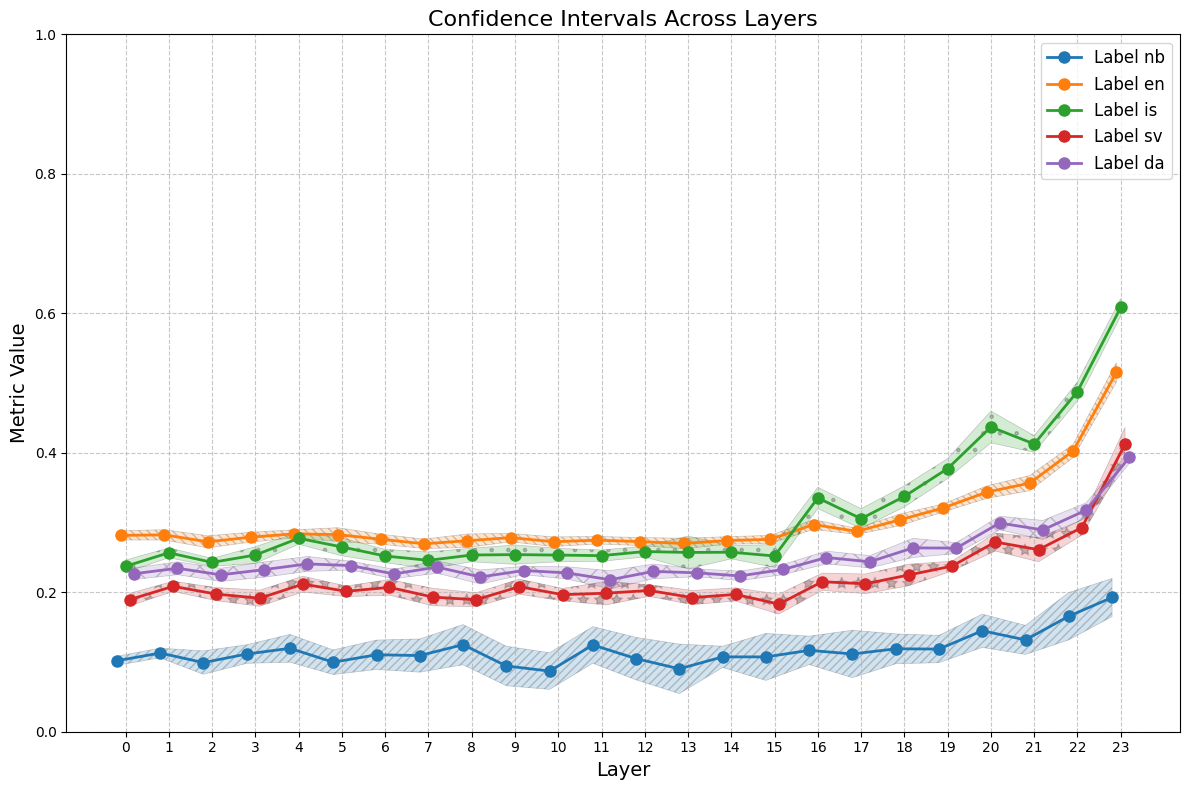

In [7]:
plot_confidence_intervals(d,meta_data, map_lab)